In [ ]:
# @title prepare yes no dataset
!wget https://us.openslr.org/resources/1/waves_yesno.tar.gz
!mkdir working
!tar -xzvf waves_yesno.tar.gz -C working

import os
import re

# Directory containing the audio files
audio_dir = '/content/working/waves_yesno/'

# Create a dictionary to store audio paths and text transcriptions
audio_transcription_dict = {}

# Iterate through the audio files in the directory
for filename in os.listdir(audio_dir):
    if filename.endswith('.wav'):
        # Extract the numeric labels from the filename
        labels = re.findall(r'\d+', filename)

        labels = [int(label) for label in labels if label.isdigit()]

        # Convert the numeric labels to "yes" and "no"
        #transcription = ' '.join(['yes' if label == 1 else 'no' for label in labels])
        transcription = ' '.join(['ඔව්' if label == 1 else 'නැහැ' for label in labels])


        # Store the audio path and transcription in the dictionary
        audio_path = os.path.join(audio_dir, filename)
        audio_transcription_dict[audio_path] = transcription

# Sort the dictionary by transcription (which ensures both lists are in the same order)
sorted_audio_transcription = sorted(audio_transcription_dict.items(), key=lambda x: x[1])

# Separate the sorted data into audio paths and transcriptions
sorted_audio_paths, sorted_transcriptions = zip(*sorted_audio_transcription)

# Create a text file to store the audio paths
paths_output_file = 'paths.txt'
with open(paths_output_file, 'w') as f_paths:
    # Write each audio path on a separate line
    f_paths.write('\n'.join(sorted_audio_paths))

print(f"Audio paths have been saved to {paths_output_file}")

# Create a text file to store the transcriptions
transcriptions_output_file = 'transcriptions.txt'
with open(transcriptions_output_file, 'w') as f_transcriptions:
    # Write each transcription on a separate line
    f_transcriptions.write('\n'.join(sorted_transcriptions))

print(f"Transcriptions have been saved to {transcriptions_output_file}")


--2023-09-27 13:07:23--  https://us.openslr.org/resources/1/waves_yesno.tar.gz
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4703754 (4.5M) [application/x-gzip]
Saving to: ‘waves_yesno.tar.gz’

waves_yesno.tar.gz  100%[===================>]   4.49M  5.71MB/s    in 0.8s    

2023-09-27 13:07:24 (5.71 MB/s) - ‘waves_yesno.tar.gz’ saved [4703754/4703754]

waves_yesno/
waves_yesno/1_0_0_0_0_0_1_1.wav
waves_yesno/1_1_0_0_1_0_1_0.wav
waves_yesno/1_0_1_1_1_1_0_1.wav
waves_yesno/1_1_1_1_0_1_0_0.wav
waves_yesno/0_0_1_1_1_0_0_0.wav
waves_yesno/0_1_1_1_1_1_1_1.wav
waves_yesno/0_1_0_1_1_1_0_0.wav
waves_yesno/1_0_1_1_1_0_1_0.wav
waves_yesno/1_0_0_1_0_1_1_1.wav
waves_yesno/0_0_1_0_1_0_0_0.wav
waves_yesno/0_1_0_1_1_0_1_0.wav
waves_yesno/0_0_1_1_0_1_1_0.wav
waves_yesno/1_0_0_0_1_0_0_1.wav
waves_yesno/1_1_0_1_1_1_1_0.wav
waves_yesno/0_0_1_1_1_1_0_0.wav
waves

In [ ]:
# @title install required libs and import them
!pip install jiwer
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

from tensorflow.keras.preprocessing.text import Tokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.4 MB/s eta 0:00:00


In [ ]:

audio_files_path = "/content/paths.txt"
texttranscribe_path = "/content/transcriptions.txt"

# Load the audio file paths and corresponding text labels
with open(audio_files_path, 'r') as f:
    audio_files = f.read().splitlines()
with open(texttranscribe_path, 'r') as f:
    audio_labels_text = f.read().splitlines()
# Create a dictionary with the data
data = {'Audio_Path': audio_files, 'Transcription': audio_labels_text}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

metadata_df  = df

# Display the first few rows of the DataFrame
print(df.head())

                                         Audio_Path  \
0  /content/working/waves_yesno/1_1_1_1_1_1_1_1.wav   
1  /content/working/waves_yesno/1_1_1_1_1_1_0_0.wav   
2  /content/working/waves_yesno/1_1_1_1_1_0_0_0.wav   
3  /content/working/waves_yesno/1_1_1_1_0_1_0_0.wav   
4  /content/working/waves_yesno/1_1_1_1_0_0_1_0.wav   

                        Transcription  
0     ඔව් ඔව් ඔව් ඔව් ඔව් ඔව් ඔව් ඔව්  
1   ඔව් ඔව් ඔව් ඔව් ඔව් ඔව් නැහැ නැහැ  
2  ඔව් ඔව් ඔව් ඔව් ඔව් නැහැ නැහැ නැහැ  
3  ඔව් ඔව් ඔව් ඔව් නැහැ ඔව් නැහැ නැහැ  
4  ඔව් ඔව් ඔව් ඔව් නැහැ නැහැ ඔව් නැහැ  


In [ ]:
text = audio_labels_text


charlevel=True

# Tokenize the labels and convert to binary matrix
tokenizer = Tokenizer(char_level=charlevel, oov_token='<UNK>')
tokenizer.fit_on_texts(text)

audio_labels = tokenizer.texts_to_sequences(text)

word_index = tokenizer.word_index
#print(word_index)

# Extract only the characters (keys) from the dictionary
characters = [char for char in word_index.keys()]

# Join the list elements into a single string
vocabresult = ''.join(characters)

# Print the result
print(vocabresult)

<UNK>ැ ඔව්නහ


In [ ]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the val set: {len(df_val)}")


Size of the training set: 54
Size of the val set: 6


## Preprocessing

We first prepare the vocabulary to be used.

In [ ]:
# The set of characters accepted in the transcription.
#characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
characters = [x for x in vocabresult]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', '<', 'U', 'N', 'K', '>', 'ැ', ' ', 'ඔ', 'ව', '්', 'න', 'හ'] (size =13)


Next, we create the function that describes the transformation that we apply to each
element of our dataset.

In [ ]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    #file = tf.io.read_file(wavs_path + wav_file + ".wav")
    file = tf.io.read_file(wav_file)
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label


## Creating `Dataset` objects

We create a `tf.data.Dataset` object that yields
the transformed elements, in the same order as they
appeared in the input.

In [ ]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    #old(list(df_train["file_name"]), list(df_train["normalized_transcription"]))
    (list(df_train["Audio_Path"]), list(df_train["Transcription"]))

)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["Audio_Path"]), list(df_val["Transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


## Visualize the data

Let's visualize an example in our dataset, including the
audio clip, the spectrogram and the corresponding label.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3476 (\N{SINHALA LETTER OYANNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Sinhala natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3520 (\N{SINHALA LETTER VAYANNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3530 (\N{SINHALA SIGN AL-LAKUNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


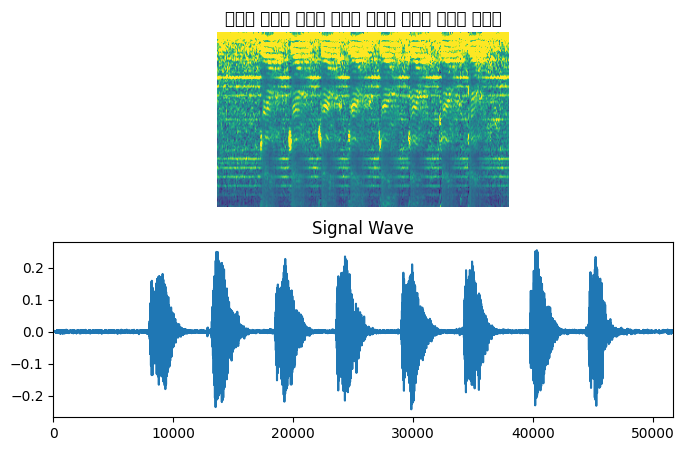

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    #file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    file = tf.io.read_file(list(df_train["Audio_Path"])[0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## Model

We first define the CTC Loss function.

In [ ]:

def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


We now define our model. We will define a model similar to
[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html).

In [ ]:

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="zmasr")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "zmasr"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                        128 

## Training and Evaluating

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


Let's start the training process.

In [ ]:
# Define the number of epochs.
epochs = 200
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)


Epoch 1/200
1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : නැහැ නැහැ නැහැ ඔව් නැහැ නැහැ නැහැ ඔව්
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : නැහැ නැහැ නැහැ ඔව් නැහැ ඔව් ඔව් නැහැ
Prediction: 
----------------------------------------------------------------------------------------------------
2/2 [==============================] - 45s 11s/step - loss: 263.7190 - val_loss: 171.5215
Epoch 2/200
1/1 [==============================] - 0s 93ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Targe

KeyboardInterrupt: ignored

## Inference

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 [==============================] - 0s 127ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.0000
----------------------------------------------------------------------------------------------------
Target    : නැහැ නැහැ ඔව් නැහැ නැහැ ඔව් ඔව් නැහැ
Prediction: නැහැ නැහැ ඔව් නැහැ නැහැ ඔව් ඔව් නැහැ
----------------------------------------------------------------------------------------------------
Target    : නැහැ නැහැ ඔව් නැහැ නැහැ ඔව් ඔව් ඔව්
Prediction: නැහැ නැහැ ඔව් නැහැ නැහැ ඔව් ඔව් ඔව්
----------------------------------------------------------------------------------------------------
Target    : නැහැ නැහැ නැහැ නැහැ ඔව් ඔව් ඔව් ඔව්
Prediction: නැහැ නැහැ නැහැ නැහැ ඔව් ඔව් ඔව් ඔව්
----------------------------------------------------------------------------------------------------
Target    : නැහැ නැහැ ඔව් නැහැ නැහැ නැහැ ඔව් නැහැ
Prediction: නැහැ නැහැ ඔව් නැහැ නැහැ නැහැ ඔව් නැහැ
----------------------------

In [ ]:

#############################################################
################### Give Audio Path And Run #################
#############################################################

aud = "/content/working/waves_yesno/0_0_1_1_1_1_0_0.wav"

#############################################################


def encode_aud(wav_file):
    """
    audio file encoder
    params : wav audio file path
    return : spectogram
     """
    file = tf.io.read_file(wav_file)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    return spectrogram


aud = encode_aud(aud)
aud = tf.expand_dims(aud, axis=0)
#Make preds by ai
pred = model.predict(aud)
#decode and detokenize it
pred = decode_batch_predictions(pred)
print(pred)


1/1 [==============================] - 3s 3s/step
['නැහැ නැහැ ඔව් ඔව් ඔව් ඔව් නැහැ නැහැ']


In [ ]:
# @title Save models
!mkdir model
import json

# Save the model weights and architecture
model.save("model/zoomasr")


#with open("model/transformer_model_architecture.json", "w") as json_file:
 #   json_file.write(model.to_json())

# Save the tokenizer vocabulary as a JSON file
with open("model/tokenizer_vocab.txt", "w", encoding="utf-8") as file:
    file.write(vocabresult)



In [ ]:
# @title load model and tokenizer
import json
import tensorflow as tf
from tensorflow import keras

# Load the tokenizer vocabulary from the JSON file
with open("model/tokenizer_vocab.txt", "r") as file:
    idx_to_char = file.read()

characters = [x for x in idx_to_char]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss




with keras.utils.custom_object_scope({'CTCLoss': CTCLoss}):
    loaded_model = tf.keras.models.load_model("model/zoomasr")




The vocabulary is: ['', '<', 'U', 'N', 'K', '>', 'ැ', ' ', 'ඔ', 'ව', '්', 'න', 'හ'] (size =13)


In [ ]:

#############################################################
################### Give Audio Path And Run #################
#############################################################

aud = "/content/working/waves_yesno/0_0_1_1_1_1_0_0.wav"

#############################################################
import numpy as np
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_aud(wav_file):
    """
    audio file encoder
    params : wav audio file path
    return : spectogram
     """
    file = tf.io.read_file(wav_file)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    return spectrogram


aud = encode_aud(aud)
aud = tf.expand_dims(aud, axis=0)
#Make preds by ai
pred = loaded_model.predict(aud)
#decode and detokenize it
pred = decode_batch_predictions(pred)
print(pred)


1/1 [==============================] - 5s 5s/step
['නැහැ නැහැ ඔව් ඔව් ඔව් ඔව් නැහැ නැහැ']


In [ ]:
# @title io ops
!zip -r yesno_zoomasr_model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/tokenizer_vocab.txt (stored 0%)
  adding: content/model/zoomasr/ (stored 0%)
  adding: content/model/zoomasr/fingerprint.pb (stored 0%)
  adding: content/model/zoomasr/variables/ (stored 0%)
  adding: content/model/zoomasr/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model/zoomasr/variables/variables.index (deflated 72%)
  adding: content/model/zoomasr/saved_model.pb (deflated 91%)
  adding: content/model/zoomasr/keras_metadata.pb (deflated 95%)
  adding: content/model/zoomasr/assets/ (stored 0%)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
